In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams.update({
    'figure.facecolor': 'none', 'axes.facecolor': 'none',
    'savefig.facecolor': 'none', 'axes.grid': False,
    'font.size': 11, 'axes.labelsize': 12,
    'axes.titlesize': 13, 'figure.figsize': (12, 5)
})
print('Setup complete.')


Setup complete.


In [2]:
def plot_ljungbox_pvalues(series, noestimatedcoef=0, nolags=25,
                          title='P-values for Ljung-Box Test', figsize=(12, 5)):
    lags = np.arange(1, nolags + 1)
    lb_results = acorr_ljungbox(series, lags=nolags, model_df=noestimatedcoef)
    pvalues = lb_results['lb_pvalue'].values
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
    ax.scatter(lags, pvalues, color='steelblue', s=40, zorder=3)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1.0, label='5% significance')
    ax.set_xlabel('Lag'); ax.set_ylabel('P-value')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=1, frameon=False)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    return fig, ax

print('Helper function defined.')


Helper function defined.


## 1. Load Data


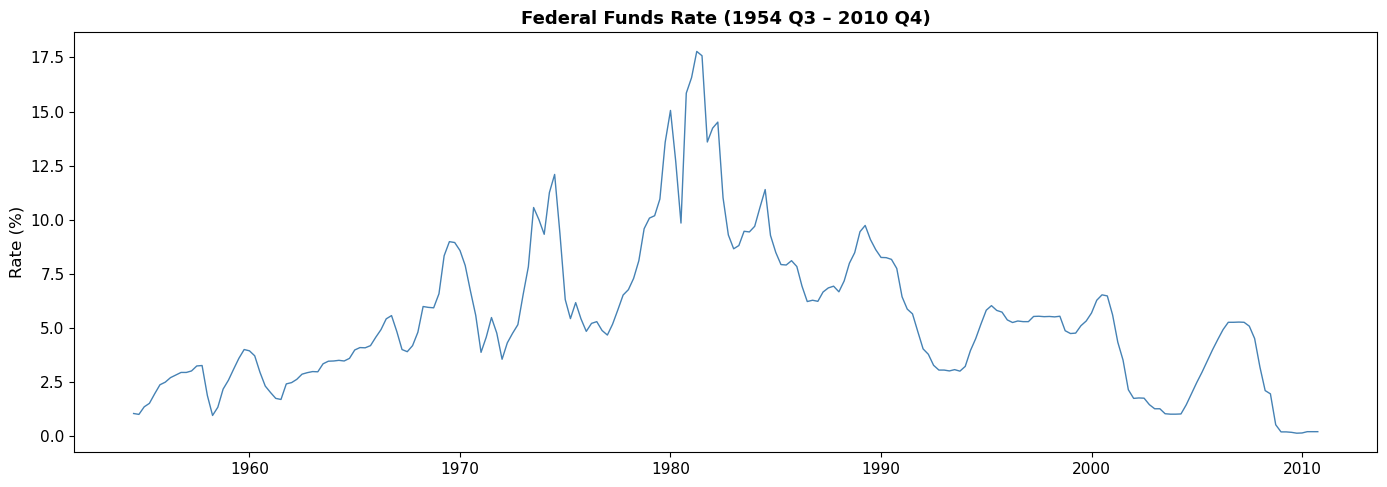

In [3]:
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds

index = pd.date_range('1954-07-01', '2010-10-01', freq='QS')
dta_fedfunds = pd.Series(fedfunds, index=index, name='fedfunds')

# Time series plot
fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
ax.plot(dta_fedfunds, color='steelblue', linewidth=1.0)
ax.set_title('Federal Funds Rate (1954 Q3 – 2010 Q4)', fontsize=13, fontweight='bold')
ax.set_ylabel('Rate (%)')
plt.tight_layout()
plt.savefig('P06_chart01.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## 2. Model A: Non-Switching Variance
$$X_t = \mu_{S_t} + X_{t-1}\beta_{S_t} + \varepsilon_t, \quad \varepsilon_t \sim \text{WN}(0, \sigma^2)$$


In [4]:
# Prepare lagged fedfunds
fedfundslag = dta_fedfunds.shift(1)
fedfundslag = fedfundslag.iloc[1:]
endog = dta_fedfunds.iloc[1:]

# Fit: non-switching variance
mod_A = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=2,
    exog=fedfundslag, order=0,
    switching_variance=False
)
res_A = mod_A.fit()
print(res_A.summary())


                        Markov Switching Model Results                        
Dep. Variable:               fedfunds   No. Observations:                  225
Model:               MarkovRegression   Log Likelihood                -264.711
Date:                Tue, 10 Feb 2026   AIC                            543.421
Time:                        11:41:18   BIC                            567.334
Sample:                    10-01-1954   HQIC                           553.073
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7245      0.289      2.510      0.012       0.159       1.290
x1             0.7631      0.034     22.629      0.0

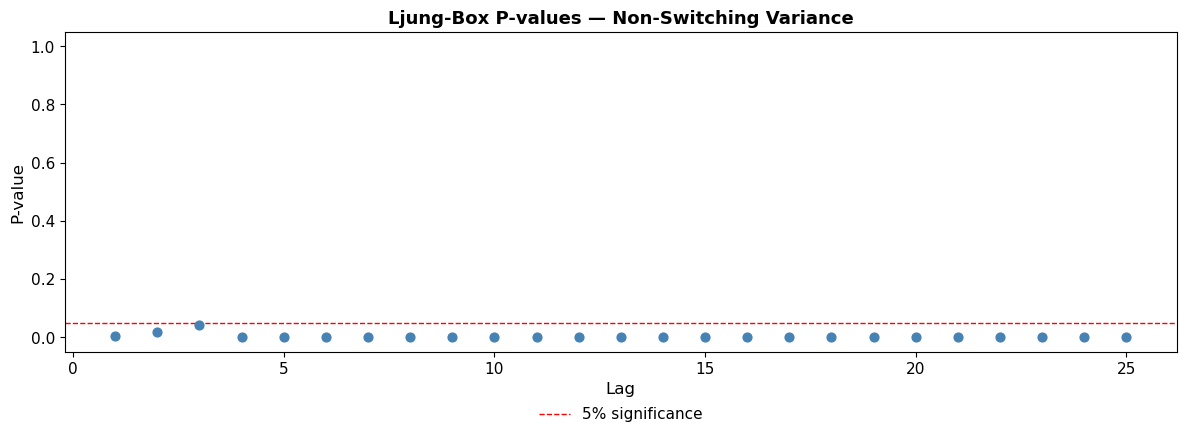

⚠️  All p-values << 0.05 → model is INADEQUATE


In [5]:
# LB test — Model A
fig, ax = plot_ljungbox_pvalues(res_A.resid, noestimatedcoef=0, nolags=25,
    title='Ljung-Box P-values — Non-Switching Variance')
plt.savefig('P06_chart02.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('⚠️  All p-values << 0.05 → model is INADEQUATE')


## 3. Model B: Switching Variance
$$X_t = \mu_{S_t} + X_{t-1}\beta_{S_t} + \varepsilon_t, \quad \varepsilon_t \sim \text{WN}(0, \sigma_{S_t}^2)$$


In [6]:
# Fit: switching variance
mod_B = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=2,
    exog=fedfundslag, order=0,
    switching_variance=True
)
res_B = mod_B.fit()
print(res_B.summary())


                        Markov Switching Model Results                        
Dep. Variable:               fedfunds   No. Observations:                  225
Model:               MarkovRegression   Log Likelihood                -277.099
Date:                Tue, 10 Feb 2026   AIC                            570.198
Time:                        11:41:18   BIC                            597.527
Sample:                    10-01-1954   HQIC                           581.228
                         - 10-01-2010                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1286      0.012     11.125      0.000       0.106       0.151
x1             0.1923      0.017     11.344      0.0

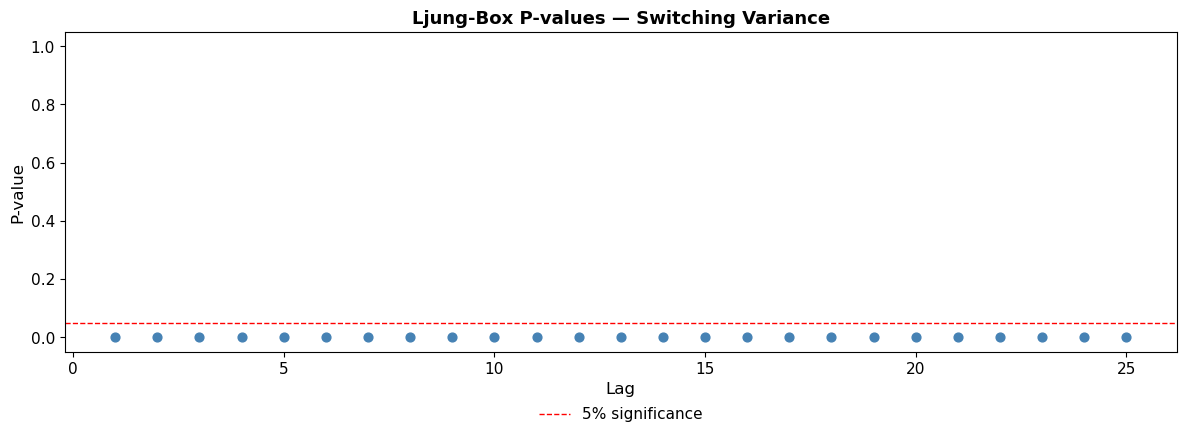

⚠️  Results are even worse with switching variance


In [7]:
# LB test — Model B
fig, ax = plot_ljungbox_pvalues(res_B.resid, noestimatedcoef=0, nolags=25,
    title='Ljung-Box P-values — Switching Variance')
plt.savefig('P06_chart03.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('⚠️  Results are even worse with switching variance')


## 4. Model Comparison


In [8]:
comparison = pd.DataFrame({
    'Model': ['Non-switching σ²', 'Switching σ²'],
    'Log-Likelihood': [res_A.llf, res_B.llf],
    'AIC': [res_A.aic, res_B.aic],
    'BIC': [res_A.bic, res_B.bic],
    'Adequate': ['No ❌', 'No ❌']
}).set_index('Model')
print(comparison.to_string())

print('\n' + '='*60)
print('CONCLUSION: Both models are inadequate.')
print('A simple 2-regime MS regression with one lag is insufficient')
print('for the federal funds rate. See Problems 7 and Example 8.7')
print('for appropriate specifications.')


                  Log-Likelihood         AIC         BIC Adequate
Model                                                            
Non-switching σ²     -264.710689  543.421377  567.334080     No ❌
Switching σ²         -277.098946  570.197892  597.526695     No ❌

CONCLUSION: Both models are inadequate.
A simple 2-regime MS regression with one lag is insufficient
for the federal funds rate. See Problems 7 and Example 8.7
for appropriate specifications.


## 5. Smoothed Regime Probabilities (Model A)


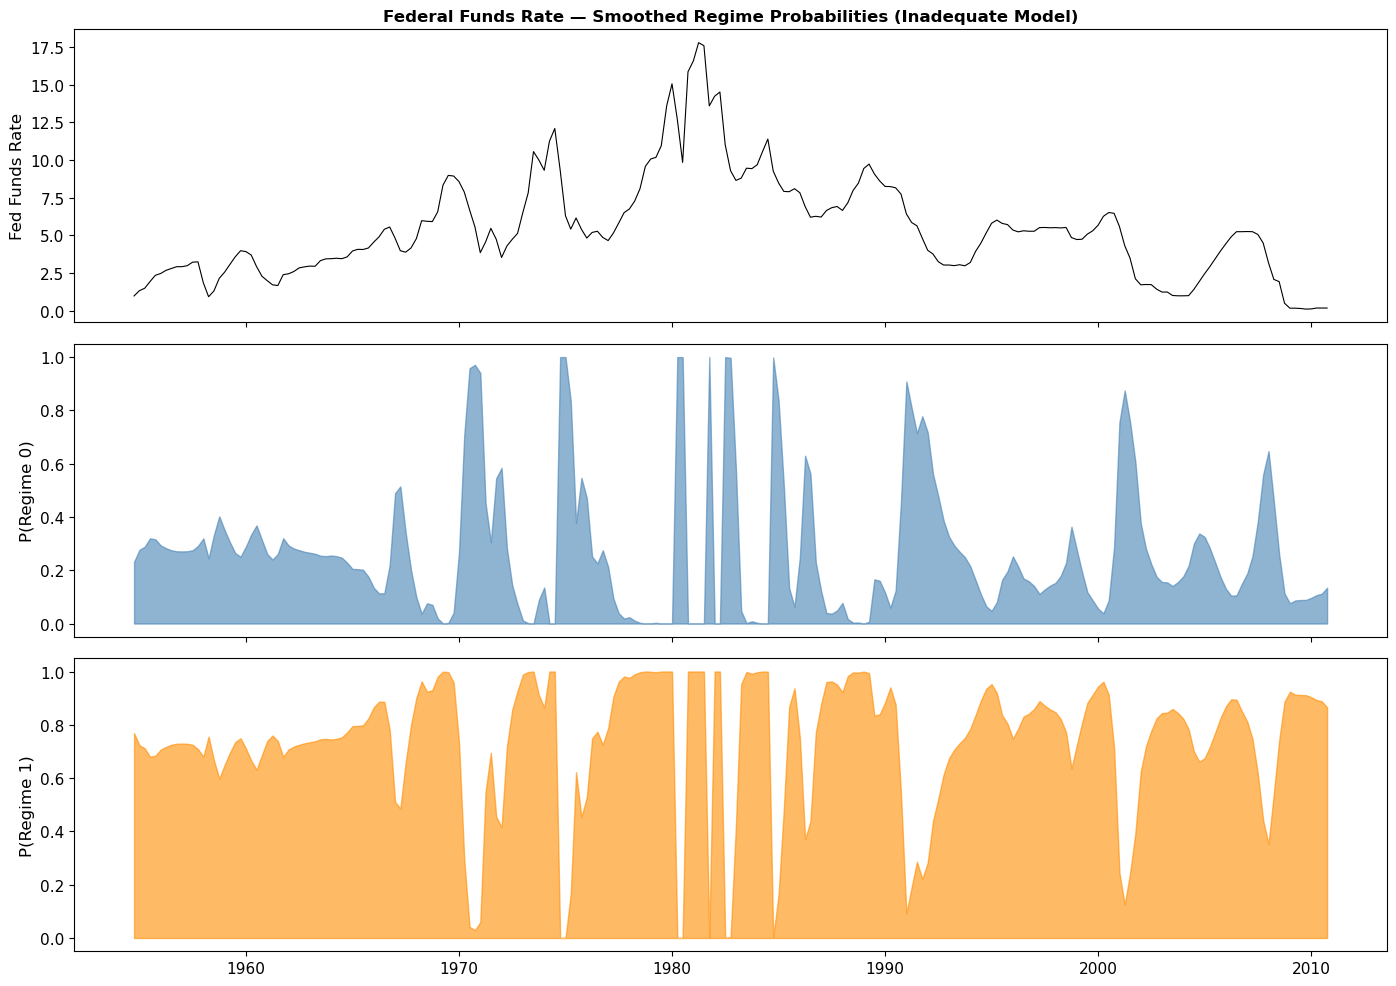

In [9]:
smoothed = res_A.smoothed_marginal_probabilities
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.patch.set_alpha(0)

ax = axes[0]
ax.patch.set_alpha(0); ax.grid(False)
ax.plot(endog, color='black', linewidth=0.8)
ax.set_ylabel('Fed Funds Rate')
ax.set_title('Federal Funds Rate — Smoothed Regime Probabilities (Inadequate Model)',
             fontsize=12, fontweight='bold')

for i, color in enumerate(['steelblue', 'darkorange']):
    ax = axes[i + 1]
    ax.patch.set_alpha(0); ax.grid(False)
    ax.fill_between(smoothed.index, smoothed.iloc[:, i], alpha=0.6, color=color)
    ax.set_ylabel(f'P(Regime {i})')
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig('P06_chart04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## Conclusion

Neither the non-switching nor the switching variance specification is adequate for this dataset. The federal funds rate requires a richer model — see Problem 7 (3 regimes, 4 exogenous regressors) and Example 8.7 for appropriate Markov switching specifications.
